In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import imread, showMatches
from detectBlobs import detectBlobs
from drawBlobs import drawBlobs
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve
from compute_sift import compute_sift
from computeMatches import computeMatches
from mergeImages import mergeImages
from ransac import ransac

import sys
%matplotlib inline

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [282]:
dataDir = os.path.join('..', 'data', 'stitching')
testExamples = ['hill', 'field', 'ledge', 'pier', 'river', 'roofs', 'building', 'uttower']
exampleIndex = 7
imageName1 = '{}1_r.jpg'.format(testExamples[exampleIndex])
imageName2 = '{}2_r.jpg'.format(testExamples[exampleIndex])

im1 = imread(os.path.join(dataDir, imageName1))
im2 = imread(os.path.join(dataDir, imageName2))

In [283]:
testExamples[exampleIndex]

'uttower'

In [284]:
cutoff = 0.001
blobs1 = detectBlobs(im1, {'cutoff': cutoff, 'level': 13})
blobs2 = detectBlobs(im2, {'cutoff': cutoff, 'level': 13})

Convolving with sigma=1.2
Convolving with sigma=1.6099689438
Convolving with sigma=2.16
Convolving with sigma=2.89794409884
Convolving with sigma=3.888
Convolving with sigma=5.21629937791
Convolving with sigma=6.9984
Convolving with sigma=9.38933888024
Convolving with sigma=12.59712
Convolving with sigma=16.9008099844
Convolving with sigma=22.674816
Convolving with sigma=30.421457972
Convolving with sigma=40.8146688
Iterating for Level=0
Iterating for Level=1
Iterating for Level=2
Iterating for Level=3
Iterating for Level=4
Iterating for Level=5
Iterating for Level=6
Iterating for Level=7
Iterating for Level=8
Iterating for Level=9
Iterating for Level=10
Iterating for Level=11
Iterating for Level=12
Convolving with sigma=1.2
Convolving with sigma=1.6099689438
Convolving with sigma=2.16
Convolving with sigma=2.89794409884
Convolving with sigma=3.888
Convolving with sigma=5.21629937791
Convolving with sigma=6.9984
Convolving with sigma=9.38933888024
Convolving with sigma=12.59712
Convolv

In [286]:
len(blobs1), len(blobs2)

(2231, 2061)

In [407]:
from scipy.spatial.distance import cdist
def computeMatches11(f1, f2):
    """ Match two sets of SIFT features f1 and f2 """
    reject_limit = .6
    matches = []
    distance_matrix = cdist(f1, f2)
    smallest_matrix = f1
    if (f2.shape[0] < f1.shape[0]):
        smallest_matrix = f2
    for n in range(smallest_matrix.shape[0]):
        currd_matrix = distance_matrix[n]
        if (np.min(currd_matrix) / np.partition(currd_matrix, 2)[1]) < reject_limit:
            matches.append([n])
    matches = np.squeeze(np.array(matches))
    return matches

439


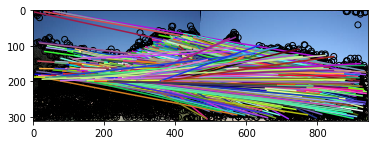

In [408]:
#Compute SIFT features
sift1 = compute_sift(im1, blobs1)
sift2 = compute_sift(im2, blobs2)

#Find the matching between features
matches = computeMatches11(sift1, sift2)
print (len(matches))
showMatches(im1, im2, blobs1, blobs2, matches)

In [439]:
def add_extra_dim(matching_blobs):
    return np.hstack([matching_blobs, np.ones((matching_blobs.shape[0], 1))])

def ransac11(matches, blobs1, blobs2, param={}):
    default_max_itr, default_reject_limit = 900, 2500 #600, .5e3
    max_iteration = param.get("max_iteration") if param.get("max_iteration") is not None else default_max_itr
    reject_limit = param.get("reject_limit") if param.get("reject_limit") is not None else default_reject_limit
    pairs = 8 #int(matches.shape[0] * 0.2) #int(matches.shape[0] * 0.1)
    constant_padding = np.array([0, 0, 1])
    blob1_matches = add_extra_dim(blobs2[:, [0, 1]][matches])
    blob2_matches = add_extra_dim(blobs1[:, [0, 1]][matches])
    total_inliers, best_inlier_model = 0, np.zeros(matches.shape[0])
    for i_ in range(max_iteration):
        idxs = np.random.choice(matches.shape[0], pairs, replace=False)
        selected1 = blob1_matches[idxs, :]
        selected2 = blob2_matches[idxs, :]
        transf = np.linalg.lstsq(selected2, selected1, rcond=None)[0]
        transf[2, :] = constant_padding
        curr_inliers = np.power(np.linalg.norm(np.dot(blob2_matches, transf) - blob1_matches, axis=1), 2) < reject_limit
        if np.sum(curr_inliers) > total_inliers:
            total_inliers = np.sum(curr_inliers)
            best_inlier_model = np.copy(curr_inliers)
            print (total_inliers)
            #print ("Itr = {}".format(i_))
    transf, _, _, _ = np.linalg.lstsq(blob2_matches[best_inlier_model], blob1_matches[best_inlier_model], rcond=None)
    
    return best_inlier_model, transf[:2, :3]

2
4
55
66
78
84
86
87
89
96


Text(0.5,1,'stitched image: uttower')

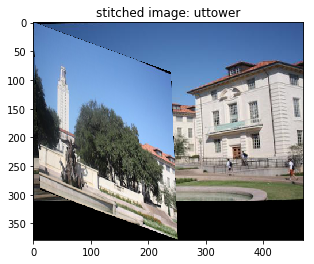

In [452]:
inliers, transf = ransac11(matches, blobs1, blobs2)
goodMatches = np.zeros_like(matches)
goodMatches[inliers] = matches[inliers]

#Merge two images and display the output
stitchIm = mergeImages(im1, im2, transf)
plt.figure()
plt.imshow(stitchIm)
plt.title('stitched image: {}'.format(testExamples[exampleIndex]))

In [438]:
transf

array([[ 5.80816637e-01,  2.05614705e-02, -5.74588656e-19],
       [ 1.55143417e-01,  9.79103443e-01,  1.11164933e-18]])

Text(0.5,1,'stitched image: uttower')

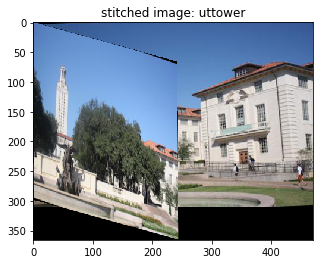

In [370]:
stitchIm = mergeImages(im1, im2, transf)
plt.figure()
plt.imshow(stitchIm)
plt.title('stitched image: {}'.format(testExamples[exampleIndex]))

In [367]:
transf

array([[ 5.14931196e-01,  5.47359001e-03, -7.50164244e-18],
       [ 1.41882042e-01,  9.59435773e-01,  1.35485168e-18]])

In [281]:
transf

array([[ 7.17926234e-01, -1.57298805e-02,  4.11219771e-18],
       [-1.23877481e-01,  9.66945954e-01, -2.16273863e-18]])

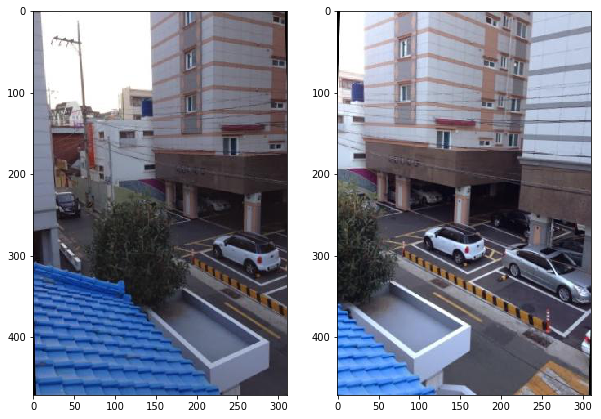

In [258]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.imshow(im2)

In [221]:
transf

array([[ 6.99477628e-01,  2.02207355e-02,  4.58516165e-19],
       [-3.20253062e-02,  9.66997815e-01, -3.26185458e-18]])